In [1]:
from gurobipy import *
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import shapefile as shp
from collections import defaultdict

start_time = time.time()

###### Helper Function

In [2]:
# Return value of variable
def VarVal(var):
    if (type(var) == gurobipy.Var):
        val = var.X

    else:
        val = 0
    return val

### Set Parameters

In [3]:
M = 100000

maxDist_D = 150
maxDist_A = 350

#Province Level
maxOpenD = 7
maxOpenA = 1

#Joined Level
TotOpenD = 14
TotOpenA = 2

### Callback Function

In [4]:
def mycallback(model, where):        
    if where == GRB.Callback.MIPSOL:
        d_temp = {}
        a_temp = {}
        c_temp = {}
        for i in Settlement_List:
            d_temp[i] = {}
            a_temp[i] = {}
        for j in District_List:
            c_temp[j] = {}
        
        for i in Settlement_List:
            for j in District_List:
                if (type(d[i][j]) == gurobipy.Var):
                    d_temp[i][j] = m.cbGetSolution(d[i][j])
                else:
                    d_temp[i][j] = 0
        
        for i in Settlement_List:
            for k in Appeals_List:
                if (type(a[i][k]) == gurobipy.Var):
                    a_temp[i][k] = m.cbGetSolution(a[i][k])
                else:
                    a_temp[i][k] = 0
                
        for j in District_List:
            for k in Appeals_List:
                if (type(c[j][k]) == gurobipy.Var):
                    c_temp[j][k] = m.cbGetSolution(c[j][k])
                else:
                    c_temp[j][k] = 0
                
        for i in Settlement_List:
            for j in District_List:
                for k in Appeals_List:
                    if (d_temp[i][j] + a_temp[i][k] - c_temp[j][k] > 1):
                        m.cbLazy(d[i][j] + a[i][k] - c[j][k] <= 1)
                    if (d_temp[i][j] + c_temp[j][k] - a_temp[i][k] > 1):
                        m.cbLazy(d[i][j] + c[j][k] - a[i][k] <= 1)             
                    


### Get District and Appeal Data

In [5]:
#Get District Court List
Districts = pd.read_csv("District_Courts.csv",sep=",")
Districts = Districts[[1,4,5]]
D = Districts.shape[0]
District_List = Districts['DIST_CODE'].tolist()

#District Dictionary
District_Dict = Districts.set_index('DIST_CODE').T.to_dict('list')

In [6]:
#Get Appeals Court List
Appeals = pd.read_csv("Appeals_Courts.csv",sep=",")
Appeals = Appeals[[1,4,5]]
A = Appeals.shape[0]
Appeals_List = Appeals['PROV_CODE'].tolist()

#Appeals Dictionary
Appeals_Dict = Appeals.set_index('PROV_CODE').T.to_dict('list')

### Solve Provinces Individually

In [7]:
Files = ["prov_code_22"]
#Files = ["prov_code_23"]

In [8]:
#Warm Variables
Full = pd.read_csv("prov_code_22_23.csv",sep=",")
Full_S_List = Full['OBJECTID'].tolist()

d_warm = {}
a_warm = {}
for i in Full_S_List:
    d_warm[i] = {}
    a_warm[i] = {}
    

c_warm = {}
for j in District_List:
    c_warm[j] = {}

openD_warm = {}
for j in District_List:
    openD_warm[j] = 0
        
openA_warm = {}
for k in Appeals_List:
    openA_warm[k] = 0

In [9]:
for Sfile in Files:
    
    Settlements=pd.read_csv("%s.csv"%Sfile,sep=",")
    Settlements = Settlements[["OBJECTID","LAT_Y","LON_X"]]
    S = Settlements.shape[0]
    Settlement_List = Settlements['OBJECTID'].tolist()
    
    #Create Dictionaries
    Settlement_Dict = Settlements.set_index('OBJECTID').T.to_dict('list')
    
    
    #Create Dictionaries for District Courthouse Distances

    Dist_D = {}

    R = 6371e3


    for d in District_List:
        d_lon = District_Dict[d][0]
        d_lat = District_Dict[d][1]
        phi2 = np.radians(d_lat)


        for s in Settlement_List:
            s_lon = Settlement_Dict[s][1]
            s_lat = Settlement_Dict[s][0]
            phi1 = np.radians(s_lat)

            #Distance to District Court
            delta_phi = np.radians(d_lat - s_lat)
            delta_lambda = np.radians(d_lon - s_lon)
            a = np.sin(delta_phi/2) * np.sin(delta_phi/2) + \
                np.cos(phi1) * np.cos(phi2) * \
                np.sin(delta_lambda/2) * np.sin(delta_lambda/2)
            c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

            Dist_D[s,d] = (R * c)/1000
    
    
    
    #Create Dictionaries for Appeals Courthouse Distances

    Dist_A = {}

    R = 6371e3

    for a in Appeals_List:
        a_lon = Appeals_Dict[a][0]
        a_lat = Appeals_Dict[a][1]
        theta_3 = np.radians(a_lat)

        for s in Settlement_List:
            s_lon = Settlement_Dict[s][1]
            s_lat = Settlement_Dict[s][0]
            theta_1 = np.radians(s_lat)

            #Distance to District Court
            delta_theta_ = np.radians(a_lat - s_lat)
            delta_lambda = np.radians(a_lon - s_lon)
            a1 = np.sin(delta_theta_/2) * np.sin(delta_theta_/2) +\
                 np.cos(theta_1) * np.cos(theta_3) * \
                 np.sin(delta_lambda/2) * np.sin(delta_lambda/2)
            c = 2 * np.arctan2(np.sqrt(a1), np.sqrt(1-a1))

            Dist_A[s,a] = (R * c)/1000

            
    #Create Model
    m = Model(Sfile)

    #Suppress output
    m.Params.OutputFlag = 1
    m.Params.LogFile="log_%s.log"%Sfile
    m.params.LazyConstraints = 1
    
    
    ### CREATE VARIABLES ### 
    
    # Create d_i_j variables
    d = {}
    for i in Settlement_List:
        d[i] = {}
        for j in District_List:
            if Dist_D[i,j] < maxDist_D:
                d[i][j] = m.addVar(vtype=GRB.BINARY, name='d_%s_%s' % (i, j))
                d[i][j].start=10000
            else:
                d[i][j] = 0
    m.update()


    # Create a_i_k variables
    a = {}
    for i in Settlement_List:
        a[i] = {}
        for k in Appeals_List:
            if Dist_A[i,k] < maxDist_A:
                a[i][k] = m.addVar(vtype=GRB.BINARY, name='a_%s_%s' % (i, k))
                a[i][k].start=0
            else:
                a[i][k] = 0
    m.update()


    # Create c_j_k variables
    c = {}
    for j in District_List:
        c[j] = {}
        for k in Appeals_List:
            c[j][k] = m.addVar(vtype=GRB.BINARY, name='c_%s_%s' % (j, k))
            c[j][k].start=0
    m.update()


    #Create openD variables
    openD = {}
    for j in District_List:
        openD[j] = m.addVar(vtype=GRB.BINARY, name='openD_%s' % (j))
        openD[j].start = 0
    m.update()


    #Create openA variables
    openA = {}
    for k in Appeals_List:
        openA[k] = m.addVar(vtype=GRB.BINARY, name='openA_%s' % (k))
        openA[k].start=0
    m.update()


    
    ### Create Constraints ###
    
    #D constraints
    for i in Settlement_List:
        m.addConstr(quicksum(d[i][j] for j in District_List) == 1)
    for j in District_List:
        m.addConstr(quicksum(d[i][j] for i in Settlement_List) <= M * openD[j])
    m.update()

    #A constraints
    for i in Settlement_List:
        m.addConstr(quicksum(a[i][k] for k in a[i]) == 1)
    for k in Appeals_List:
        m.addConstr(quicksum(a[i][k] for i in Settlement_List) <= M * openA[k])
    m.update()

    #C constraints
    for j in District_List:
        m.addConstr(quicksum(c[j][k] for k in c[j]) == openD[j])
    for k in Appeals_List:
        m.addConstr(quicksum(c[j][k] for j in District_List) <= M*openA[k])
    m.update()

    #Max Open Constraints
    m.addConstr(quicksum(openD[j] for j in District_List) <= maxOpenD)
    m.addConstr(quicksum(openA[k] for k in Appeals_List) <= maxOpenA)
    m.update()
    
    
    ### SET OBJECTIVE FUNCTION ###
    
    m.setObjective(
            quicksum(   quicksum(   Dist_D[i,j]*d[i][j] for i in Settlement_List)    for j in District_List) + \
            quicksum(   quicksum(   Dist_A[i,k]*a[i][k] for i in Settlement_List)    for k in Appeals_List), GRB.MINIMIZE)
    m.update()
    
    m.optimize(mycallback)
    m.write("out_%s.sol"%Sfile)
    
    ### Compile Results ###
    for i in Settlement_List:
        for j in District_List:
            d_warm[i][j] = VarVal(d[i][j])
    
    for i in Settlement_List:
        for k in Appeals_List:
            a_warm[i][k] = VarVal(a[i][k])
            
    for j in District_List:
        for k in Appeals_List:
            c_warm[j][k] = VarVal(c[j][k])
            
    for j in District_List:
        if (openD_warm[j] == 0):
            openD_warm[j] = VarVal(openD[j])
    
    for k in Appeals_List:
        if (openA_warm[k] == 0):

            openA_warm[k] = VarVal(openA[k])

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LogFile to log_prov_code_22.log
   Prev: gurobi.log  Default: 
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 5166 rows, 128414 columns and 257262 nonzeros
Variable types: 0 continuous, 128414 integer (128414 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [7e-01, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+00]
Found heuristic solution: objective 427142
Presolve removed 2524 rows and 59682 columns
Presolve time: 3.75s
Presolved: 2642 rows, 68732 columns, 137546 nonzeros

MIP start did not produce a new incumbent solution
MIP start violates constraint R0 by 349999.000000000

Variable types: 0 continuous, 68732 integer (68732 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -3.8023445e+05   2.151117e+03   0.00000

In [10]:
end_time = time.time()
print(end_time-start_time)

160.11337995529175


### Plotting

In [11]:
# DOUT - District Assignments

DOUT = pd.DataFrame.from_dict({(i,j): VarVal(d[i][j]) 
                           for i in d.keys() 
                           for j in d[i].keys()},
                           orient='index')

Settlements_DOUT = [i[0] for i in DOUT.index]
Districts_DOUT = [i[1] for i in DOUT.index]

DOUT['Settlement'] = Settlements_DOUT
DOUT['DistrictCourts'] = Districts_DOUT

DOUT = DOUT[DOUT[0] == 1.0]

In [12]:
#AOUT - Appeals Assignments

AOUT = pd.DataFrame.from_dict({(i,j): VarVal(a[i][j]) 
                           for i in a.keys() 
                           for j in a[i].keys()},
                           orient='index')

Settlements_AOUT = [i[0] for i in AOUT.index]
Appeals_AOUT = [i[1] for i in AOUT.index]

AOUT['Settlement'] = Settlements_AOUT
AOUT['AppealsCourts'] = Appeals_AOUT

AOUT = AOUT[AOUT[0] == 1.0]

In [13]:
#COUT - Appeals Assignments

COUT = pd.DataFrame.from_dict({(i,j): VarVal(c[i][j]) 
                           for i in c.keys() 
                           for j in c[i].keys()},
                           orient='index')

Districts_COUT = [i[0] for i in COUT.index]
Appeals_COUT = [i[1] for i in COUT.index]

COUT['DistrictCourts'] = Districts_COUT
COUT['AppealsCourts'] = Appeals_COUT

COUT = COUT[COUT[0] == 1.0]

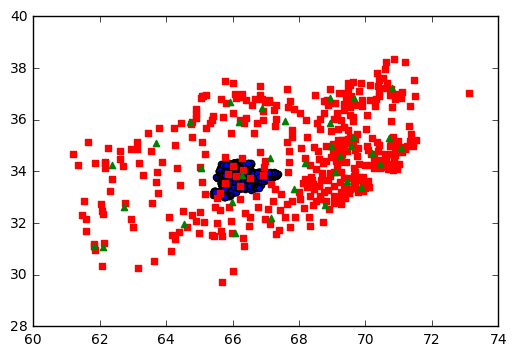

In [14]:
plt.scatter(Settlements['LON_X'],Settlements['LAT_Y'])
plt.scatter(Districts['LON_X'],Districts['LAT_Y'], color='Red', marker = 's')
plt.scatter(Appeals['LON_X'],Appeals['LAT_Y'], color='Green', marker = '^')
plt.show()

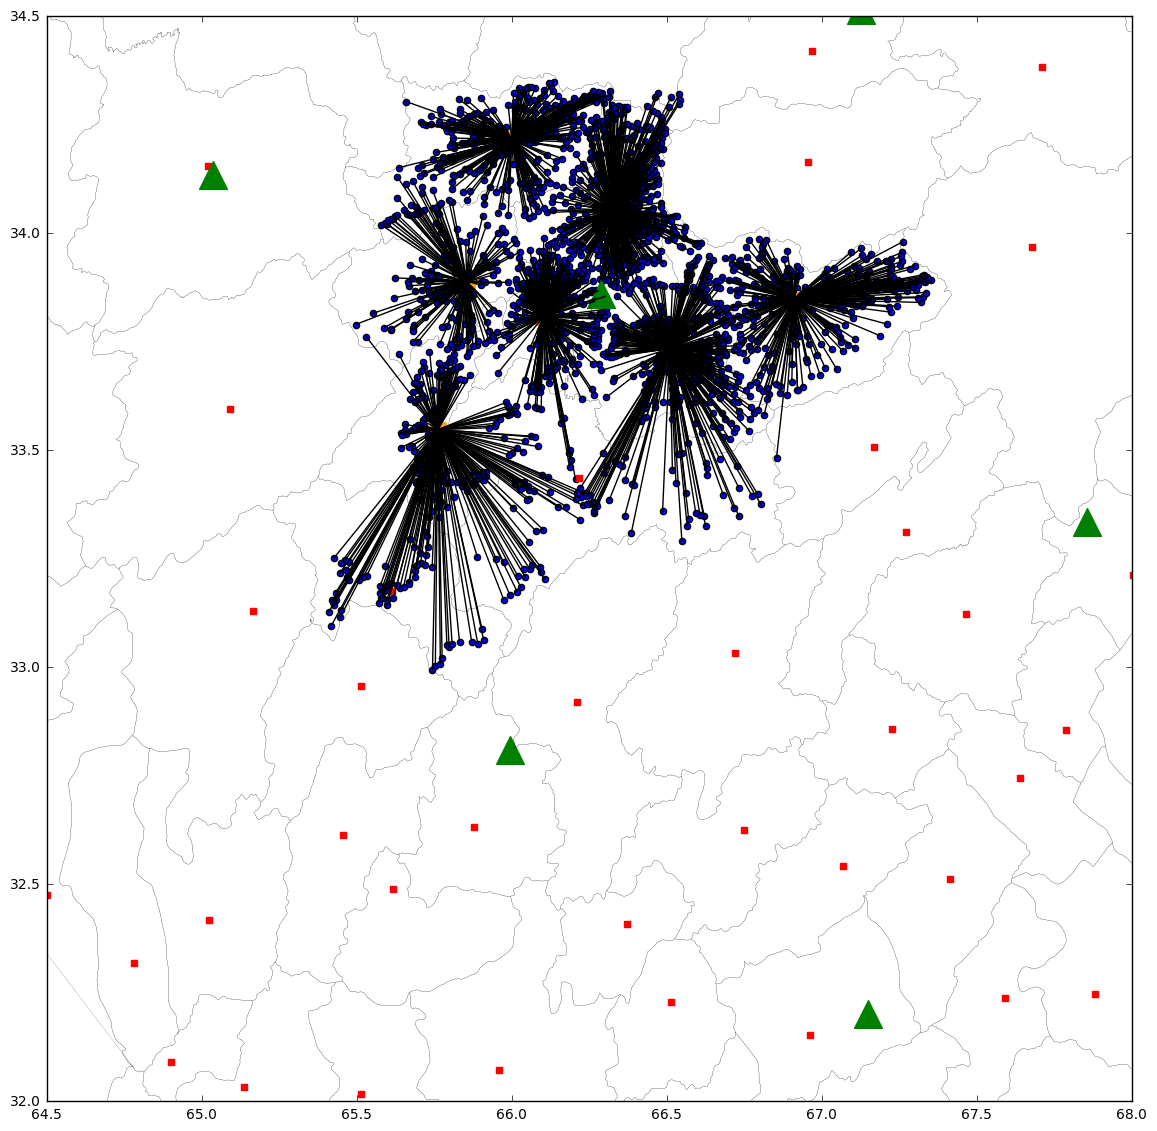

In [15]:
#Drawing Lines
plt.figure(figsize=(14,14))

#Plotting Points    
plt.scatter(Settlements['LON_X'],Settlements['LAT_Y'])
plt.scatter(Districts['LON_X'],Districts['LAT_Y'], color='Red', marker = 's',s=25)
plt.scatter(Appeals['LON_X'],Appeals['LAT_Y'], color='Green', marker = '^',s = 400)

for index,row in DOUT.iterrows():
    s = row['Settlement'] 
    d = row['DistrictCourts']
    #Get District number that Settlement is linked to
    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    Sett = Settlements.loc[Settlements['OBJECTID'] == s]
    X = [Sett.iloc[0,2],Dist.iloc[0,1]]
    Y = [Sett.iloc[0,1],Dist.iloc[0,2]]
    plt.scatter(Dist.iloc[0,1],Dist.iloc[0,2], color='Orange', marker = 's',s = 100)
    plt.plot(X,Y,zorder=1, color="Black")



axes = plt.gca()
axes.set_xlim([64.5,68])
axes.set_ylim([32,34.5])

sf = shp.Reader("Afghanistan_Districts","rb")
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color='k',linewidth=0.1)

plt.show()

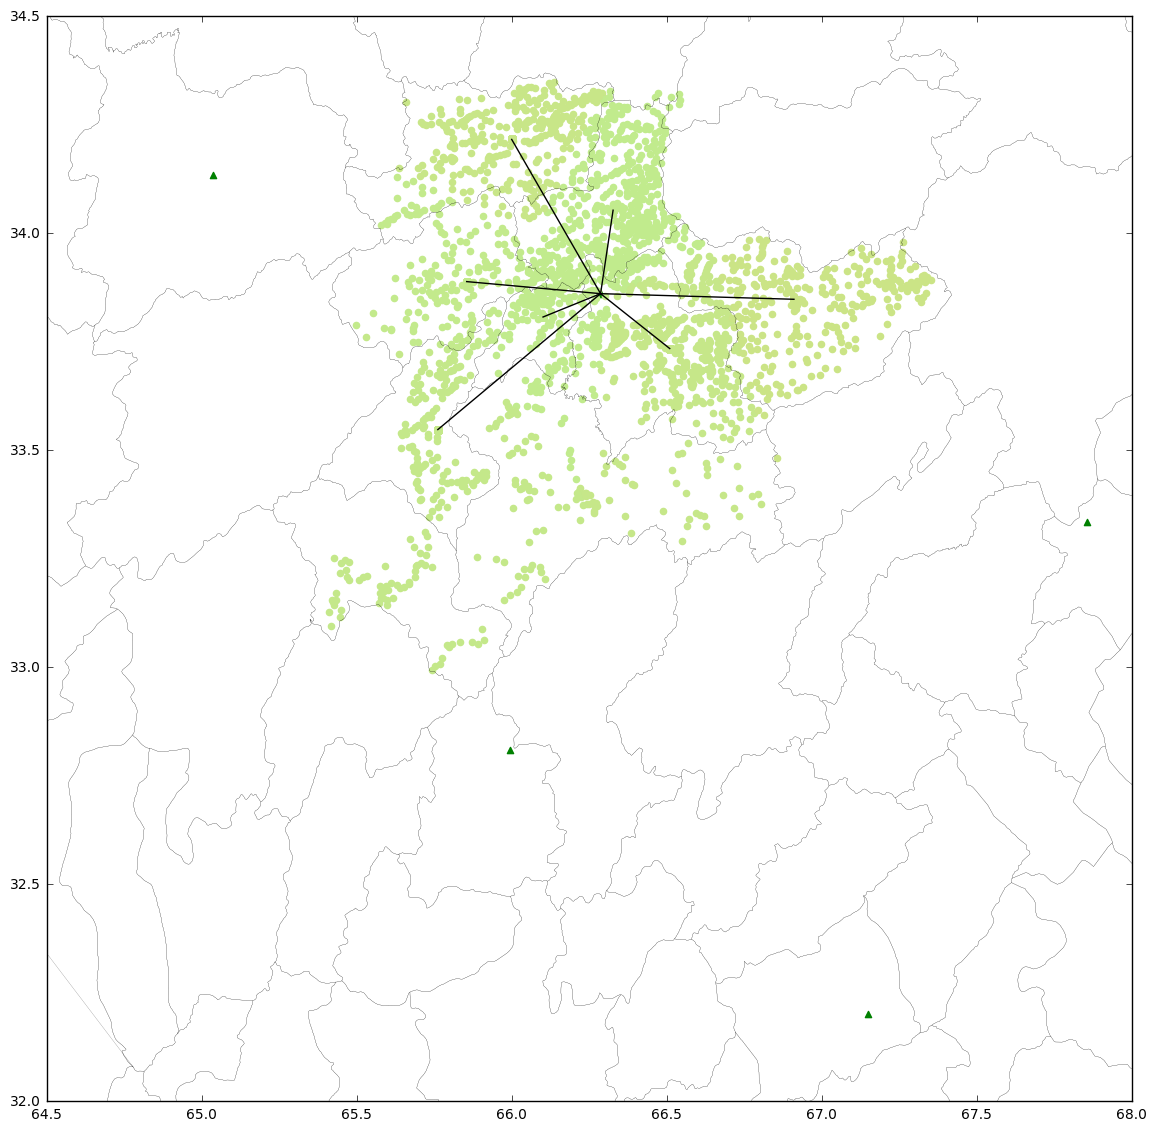

In [16]:
#Draw Lines
plt.figure(figsize=(14,14))

for index,row in COUT.iterrows():
    d = row['DistrictCourts'] 
    a = row['AppealsCourts']

    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    App = Appeals.loc[Appeals['PROV_CODE'] == a]

    X = [Dist.iloc[0,1],App.iloc[0,1]]
    Y = [Dist.iloc[0,2],App.iloc[0,2]]

    plt.plot(X,Y,zorder=1, color="Black")
    
clr = cm.rainbow(np.linspace(0, 1, D))
for a in range(A):
    X = Appeals.iloc[a,1]
    Y = Appeals.iloc[a,2]
    plt.scatter(X,Y, color="Green", marker = '^')
    
for index,row in DOUT.iterrows():   
    d = row['DistrictCourts'] 
    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    X = Dist.iloc[0,1]
    Y = Dist.iloc[0,2]
    c = Dist.index[0]
    plt.scatter(X,Y, color=clr[c], marker = 's')
    
for index,row in DOUT.iterrows():
    s = row['Settlement'] 
    d = row['DistrictCourts']
    #Get District number that Settlement is linked to
    Dist = Districts.loc[Districts['DIST_CODE'] == d]
    Sett = Settlements.loc[Settlements['OBJECTID'] == s]

    c = Dist.index[0]
    X = Sett.iloc[0,2]                                                     
    Y = Sett.iloc[0,1]
    plt.scatter(X,Y, color=clr[c])
          
axes = plt.gca()
axes.set_xlim([64.5,68])
axes.set_ylim([32,34.5])

sf = shp.Reader("Afghanistan_Districts","rb")
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y,color='k',linewidth=0.1)
plt.show()